In [146]:
#Import processed data for clustering
 
import pandas as pd

df = pd.read_csv("../data/crypto-markets-processed.csv")
df['date'] = pd.to_datetime(df['date'])
print(df.shape)
df.head()

(776561, 20)


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,daily_return,volume_change,sma_7,ema_14,rsi_14,atr_14,label
0,0chain,ZCN,0chain,2018-07-17,441,0.426759,0.529069,0.421942,0.497478,121127.0,19899120.0,0.7051,0.11,0.165712,0.446552,0.449708,0.506991,49.929569,0.066502,1
1,0chain,ZCN,0chain,2018-07-18,441,0.497499,0.518483,0.457703,0.486524,62921.0,19460960.0,0.4742,0.06,-0.022060,-0.480537,0.454008,0.504262,48.334177,0.065893,0
2,0chain,ZCN,0chain,2018-07-19,441,0.486397,0.486397,0.439271,0.440240,87071.0,17609600.0,0.0206,0.05,-0.094896,0.383815,0.458029,0.495726,42.198661,0.063976,0
3,0chain,ZCN,0chain,2018-07-20,441,0.440344,0.440344,0.388898,0.396128,135686.0,15845120.0,0.1405,0.05,-0.100412,0.558337,0.451438,0.482446,37.334404,0.062726,0
4,0chain,ZCN,0chain,2018-07-21,441,0.396202,0.399500,0.374099,0.379937,61702.0,15197480.0,0.2298,0.03,-0.041052,-0.545259,0.440131,0.468778,35.707439,0.059107,0


In [147]:
# Get top 50 coins by average market cap (or volume)
top_coins = (
    df.groupby('name')['market']
    .mean()
    .sort_values(ascending=False)
    .head(50)
    .index
)

# Filter original DataFrame
df_top = df[df['name'].isin(top_coins)].copy()

In [149]:
#Prepare data for clustering based on risk profile -> Rolling 90 days risk snapshot with an update every 30 days
window_size = 90
step_size = 30
risk_snapshots = []

coins = df_top['name'].unique()

for coin in coins:
    coin_df = df_top[df_top['name'] == coin].copy()
    coin_df = coin_df.sort_values('date')
    
    for start in range(0, len(coin_df) - window_size + 1, step_size):
        window = coin_df.iloc[start:start+window_size]
        if len(window) < window_size:
            continue

        snapshot = {
            'coin': coin,
            'end_date': window['date'].iloc[-1],
            'volatility': window['daily_return'].std(),
            'avg_spread': window['spread'].mean(),
            'avg_volume_volatility': window['volume_change'].std(),
            'avg_rsi': window['rsi_14'].mean(),
            'avg_atr': window['atr_14'].mean(),
            'market_beta': window['market'].mean(),  # rough beta
            'avg_return': window['daily_return'].mean(),
            'close': window['close'].iloc[-1]
        }

        risk_snapshots.append(snapshot)

In [150]:
#Convert to dataframe and view
risk_df = pd.DataFrame(risk_snapshots)
risk_df

,coin,end_date,volatility,avg_spread,avg_volume_volatility,avg_rsi,avg_atr,market_beta,avg_return,close
0,0x,2017-11-27,0.079845,0.025000,0.471686,47.148131,0.030174,1.067939e+08,-0.001673,0.233117
1,0x,2017-12-27,0.079256,0.038556,0.476151,54.391400,0.029182,1.291384e+08,0.014453,0.669701
2,0x,2018-01-26,0.106059,0.151778,0.561578,62.633762,0.105925,3.456857e+08,0.030115,2.040000
3,0x,2018-02-25,0.124797,0.221667,0.591813,61.158292,0.195997,5.210393e+08,0.021768,0.974205
4,0x,2018-03-27,0.115616,0.225111,1.022246,51.611830,0.224687,5.761609e+08,0.005303,0.637713
...,...,...,...,...,...,...,...,...,...,...
1034,Zilliqa,2018-07-13,0.085332,0.012889,0.590383,52.150538,0.012238,7.777005e+08,0.003897,0.066479
1035,Zilliqa,2018-08-12,0.064477,0.009222,0.428363,42.183708,0.010634,6.565730e+08,-0.014471,0.037398
1036,Zilliqa,2018-09-11,0.081465,0.006222,0.567146,40.220325,0.007355,4.541886e+08,-0.007880,0.033339
1037,Zilliqa,2018-10-11,0.076559,0.003556,0.594028,42.645935,0.005112,3.521647e+08,-0.005900,0.031725


c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

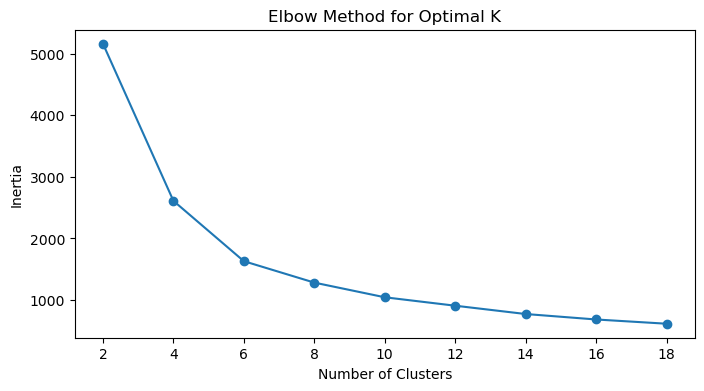

In [151]:
#Exclude coin name, date and close for clustering
features = ['volatility', 'avg_spread', 'avg_volume_volatility', 'avg_rsi', 'avg_atr', 'avg_return', 'market_beta']
X = risk_df[features]

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply KMeans clustering
inertias = []
K = list(range(2, 20, 2))

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

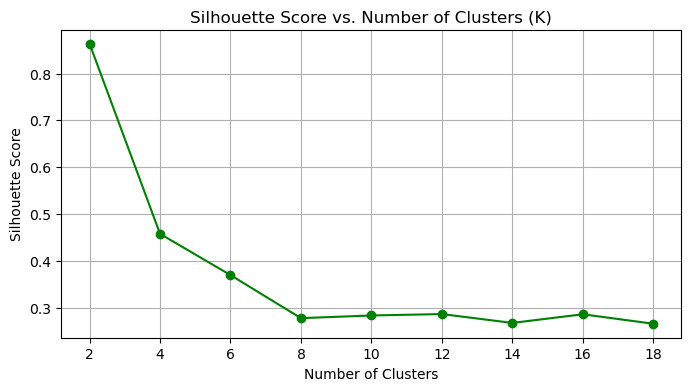

In [152]:
from sklearn.metrics import silhouette_score

# Evaluate silhouette scores for same K range
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette score curve
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

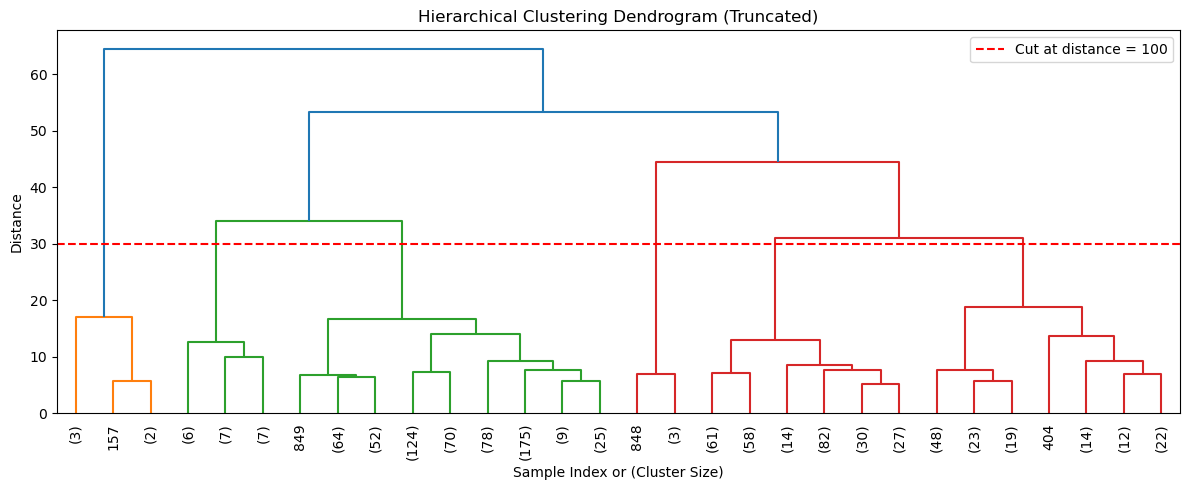

In [153]:
#Hierechical Clustering (Dendogram)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Select features for clustering
features = ['volatility', 'avg_spread', 'avg_volume_volatility', 'avg_rsi', 'avg_atr', 'avg_return', 'market_beta']
X = risk_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform hierarchical clustering
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram with a cut line specified. Attempt to do between large gaps prior to appearance of many short merges
plt.figure(figsize=(12, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.axhline(y=30, color='red', linestyle='--', label='Cut at distance = 100')
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.legend()
plt.tight_layout()
plt.show()

The elbow (inertia) method measures within cluster compactness (how close points are to centroid) and gives us a k of 6.
The silhouette score measures how well seperated the clusters are (reduces overlap and keeps them distinct) and highest score is when k = 2.
A hierarchical cluster (dendogram) shows us the split at different levels. Drawing a line at natural split points that maximize gaps between merges. Dashed line shows our cut at about k=5 ot 6.
From these analysis, we will use the optimzal k = 6.

In [154]:
# Apply KMeans clustering using the optimal k from above analyses.
features = ['volatility', 'avg_spread', 'avg_volume_volatility', 'avg_rsi', 'avg_atr', 'avg_return', 'market_beta']
X = risk_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=6, random_state=42)

#Add cluster numbers to the dataframe
risk_df['risk_cluster'] = kmeans.fit_predict(X_scaled)

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


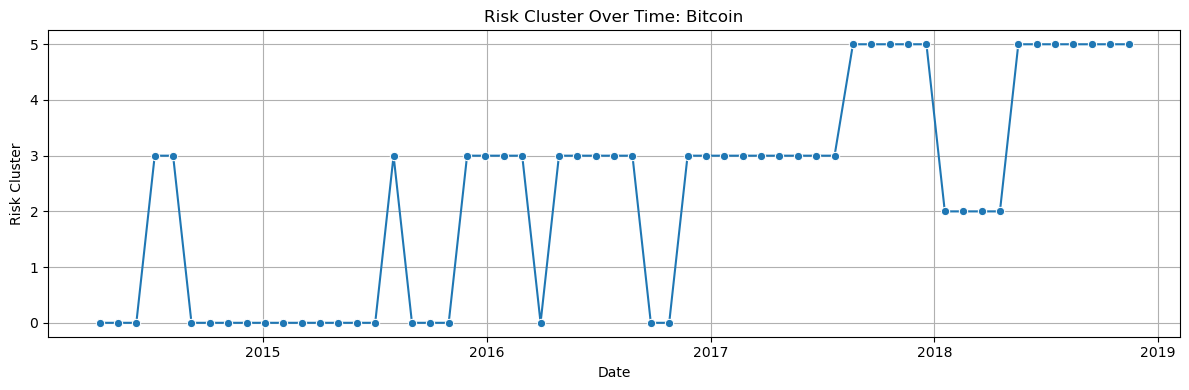

In [155]:
#Plotting how the risk profile changes with time for a particular coin
import matplotlib.pyplot as plt
import seaborn as sns

def plot_risk_cluster_timeline(coin_name):
    coin_risk = risk_df[risk_df['coin'] == coin_name].sort_values('end_date')
    
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=coin_risk, x='end_date', y='risk_cluster', marker='o')
    plt.title(f'Risk Cluster Over Time: {coin_name}')
    plt.xlabel('Date')
    plt.ylabel('Risk Cluster')
    plt.yticks(sorted(risk_df['risk_cluster'].unique()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Show Example with Bitcoin
plot_risk_cluster_timeline('Bitcoin')  # or 'ETH', 'ADA', etc.

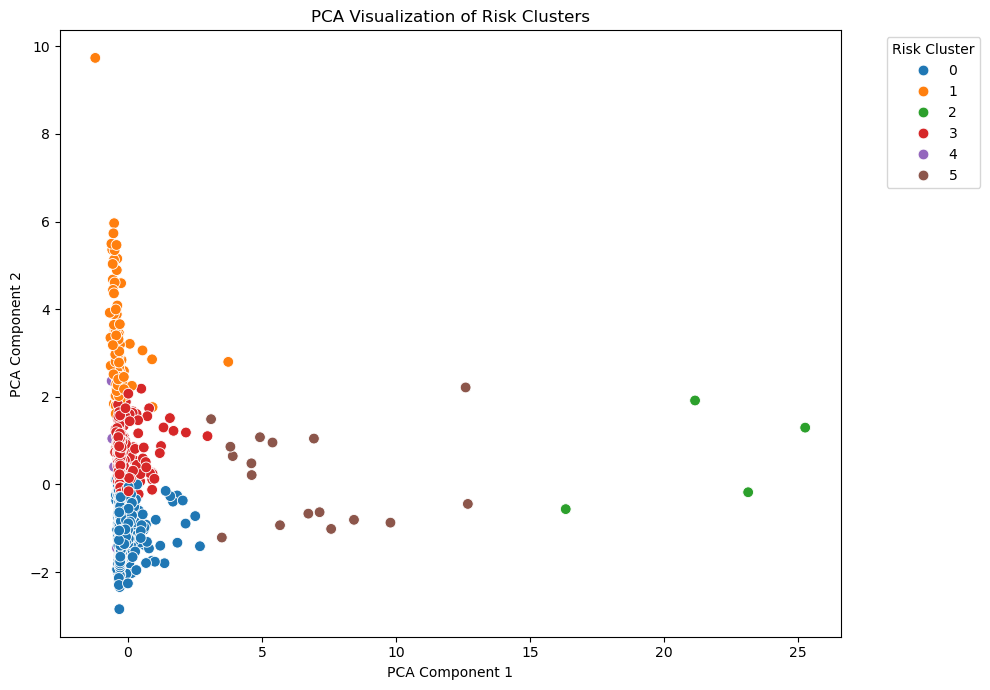

In [156]:
#PCA visualization of the clusters using optimal k

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reuse the scaled data used in KMeans
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Use scaled data

# Assign to DataFrame
risk_df['pca_1'] = X_pca[:, 0]
risk_df['pca_2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=risk_df,
    x='pca_1',
    y='pca_2',
    hue='risk_cluster',
    palette='tab10',
    s=60
)
plt.title('PCA Visualization of Risk Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Risk Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [157]:
# Group by cluster to analyze average risk features
cluster_profiles = risk_df.groupby('risk_cluster')[['volatility', 'avg_spread', 'avg_volume_volatility', 'avg_rsi', 'avg_atr', 'avg_return', 'market_beta']
].mean().round(3)

display(cluster_profiles)

,volatility,avg_spread,avg_volume_volatility,avg_rsi,avg_atr,avg_return,market_beta
risk_cluster,,,,,,,
0,0.060,4.734,2.062,44.113,5.436,-0.003,2.174441e+09
1,0.151,4.200,1.309,60.639,3.364,0.032,2.058043e+09
2,0.065,1121.918,0.246,51.751,1125.052,0.002,1.875219e+11
3,0.082,7.500,1.086,55.122,6.851,0.010,2.720260e+09
4,0.083,1.204,844.691,51.087,1.219,0.009,8.405480e+08
5,0.055,279.114,0.307,53.061,278.564,0.003,9.294657e+10


In [158]:
#From the above average risk features per group, manually assign grouping based on risk, volatility and returns
cluster_risk_labels = {
    0: "Medium Risk / Mod Volatility / Negative Return",                   # Cluster 0
    1: "High Risk / High Volatility / Strong Positive Return",             # Cluster 1
    2: "Low Risk / Low Liquidity / Low Return / Outlier Spread",           # Cluster 2
    3: "Medium-High Risk / High Volatility / Positive Return",             # Cluster 3
    4: "High Risk / Microcap Movers / Spiky Volume",                       # Cluster 4
    5: "Low Risk / High Market Cap / Low Return"                           # Cluster 5
}

In [159]:
# Color map for future plots
risk_colors = {
    "Low Risk / High Market Cap / Low Return": "green",
    "Low Risk / Low Liquidity / Low Return / Outlier Spread": "limegreen",
    "Medium Risk / Mod Volatility / Negative Return": "gold",
    "Medium-High Risk / High Volatility / Positive Return": "orange",
    "High Risk / High Volatility / Strong Positive Return": "orangered",
    "High Risk / Microcap Movers / Spiky Volume": "darkred"
}

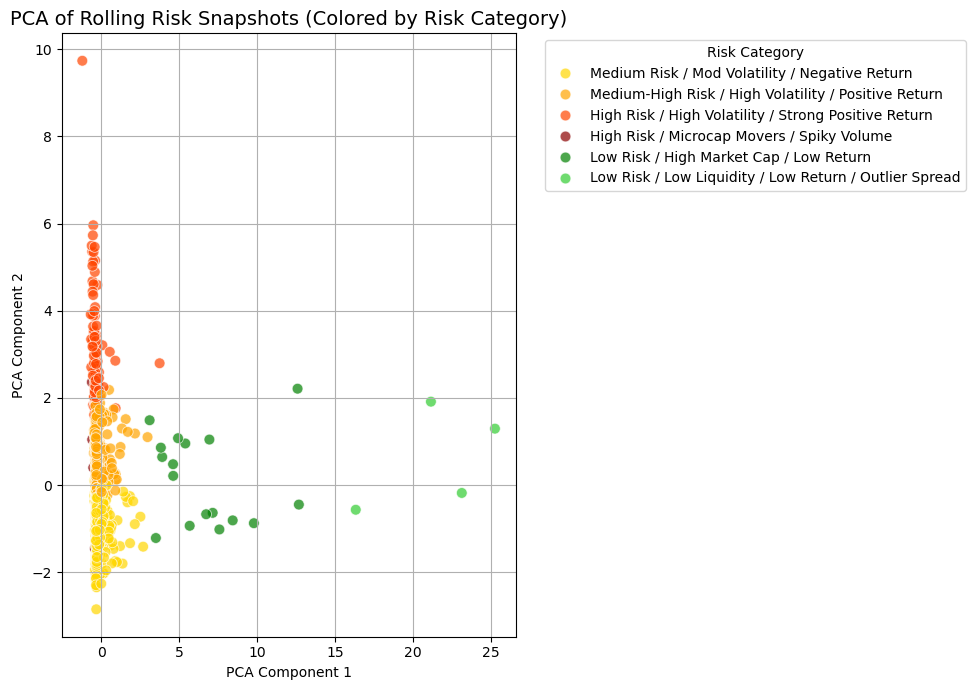

In [160]:
#PCA cluster mapping using described categories and colours

import matplotlib.pyplot as plt
import seaborn as sns

# Map labels and colors
risk_df['risk_label'] = risk_df['risk_cluster'].map(cluster_risk_labels)
risk_df['color'] = risk_df['risk_label'].map(risk_colors)

# Plot PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=risk_df,
    x='pca_1', y='pca_2',
    hue='risk_label',
    palette=risk_colors,
    alpha=0.7,
    s=60
)

plt.title('PCA of Rolling Risk Snapshots (Colored by Risk Category)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [161]:
#List so that plots are consistent in the order from low to higher risk clusters
ordered_risk_labels = [
    "Low Risk / High Market Cap / Low Return",
    "Low Risk / Low Liquidity / Low Return / Outlier Spread",
    "Medium Risk / Mod Volatility / Negative Return",
    "Medium-High Risk / High Volatility / Positive Return",
    "High Risk / High Volatility / Strong Positive Return",
    "High Risk / Microcap Movers / Spiky Volume"
]

#ensure end_date is in proper datetime format
risk_df['end_date'] = pd.to_datetime(risk_df['end_date'])

# Create mapping
risk_label_to_y = {label: i for i, label in enumerate(ordered_risk_labels)}
y_to_risk_label = {i: label for label, i in risk_label_to_y.items()}

risk_df['risk_label_y'] = risk_df['risk_label'].map(risk_label_to_y)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_multi_coin_risk_timelines_with_years(coin_list, cols=3):
    rows = (len(coin_list) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3.5), sharex=True)
    axs = axs.flatten()

    for i, coin in enumerate(coin_list):
        coin_data = risk_df[risk_df['coin'] == coin].sort_values('end_date')

        axs[i].scatter(
            coin_data['end_date'],
            coin_data['risk_label_y'],
            c=coin_data['color'],
            s=60,
            edgecolor='black'
        )

        axs[i].set_title(coin, fontsize=10)
        axs[i].set_yticks(list(y_to_risk_label.keys()))
        axs[i].set_yticklabels(list(y_to_risk_label.values()))
        
        # Force year ticks
        axs[i].xaxis.set_major_locator(mdates.YearLocator())  # tick every year
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axs[i].tick_params(axis='x', rotation=45)

        axs[i].grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    # Add spacing to ensure labels fit
    fig.subplots_adjust(hspace=0.5, bottom=0.15)

    fig.suptitle('Risk Cluster Timelines by Coin (Yearly Ticks)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

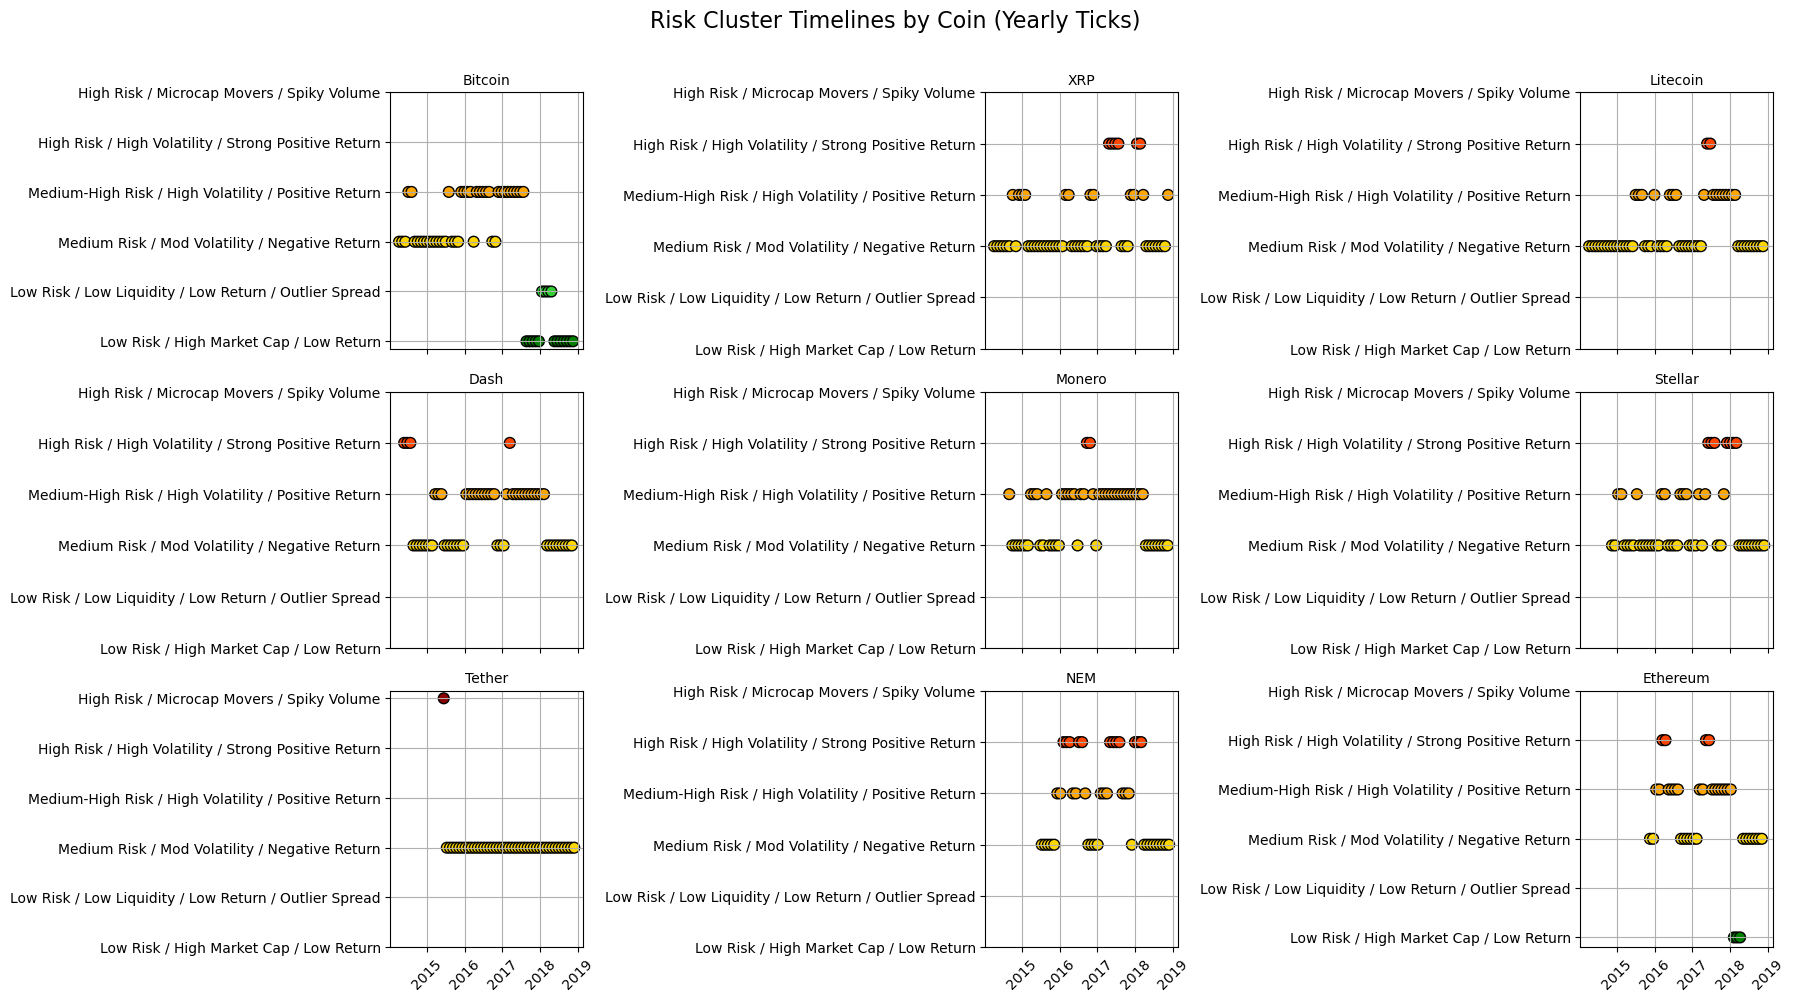

In [162]:
# Choose 9 coins to visualize
coins_to_plot = risk_df['coin'].value_counts().head(9).index.tolist()
plot_multi_coin_risk_timelines_with_years(coins_to_plot)

In [164]:
#Performance stats per cluster

import numpy as np
import pandas as pd

def calculate_risk_cluster_stats(risk_df):
    # Group by cluster
    grouped = risk_df.groupby('risk_label')

    # Define stats
    stats = grouped.agg({
        'avg_return': ['mean', 'std'],
        'volatility': 'mean',
        'coin': 'count'
    })

    # Flatten column names
    stats.columns = ['avg_return_mean', 'avg_return_std', 'volatility_mean', 'n_obs']

    # Sharpe Ratio (assuming risk-free rate = 0)
    stats['sharpe'] = stats['avg_return_mean'] / stats['avg_return_std']

    # Win rate (positive returns)
    win_rates = (
        risk_df[risk_df['avg_return'] > 0]
        .groupby('risk_label')['avg_return']
        .count()
        / grouped['avg_return'].count()
    )
    stats['win_rate'] = win_rates

    return stats.sort_values('sharpe', ascending=False)

In [165]:
cluster_perf = calculate_risk_cluster_stats(risk_df)
print(cluster_perf.round(3))

                                                    avg_return_mean  \
risk_label                                                            
High Risk / High Volatility / Strong Positive R...            0.032   
Medium-High Risk / High Volatility / Positive R...            0.010   
High Risk / Microcap Movers / Spiky Volume                    0.009   
Low Risk / High Market Cap / Low Return                       0.003   
Low Risk / Low Liquidity / Low Return / Outlier...            0.002   
Medium Risk / Mod Volatility / Negative Return               -0.003   

                                                    avg_return_std  \
risk_label                                                           
High Risk / High Volatility / Strong Positive R...           0.012   
Medium-High Risk / High Volatility / Positive R...           0.006   
High Risk / Microcap Movers / Spiky Volume                   0.009   
Low Risk / High Market Cap / Low Return                      0.007   
Low Risk / 

In [166]:
def plot_cluster_performance(cluster_perf):
    fig, ax = plt.subplots(figsize=(10, 5))
    cluster_perf['sharpe'].plot(kind='barh', color='teal', ax=ax)
    ax.set_title('Sharpe Ratio by Risk Cluster')
    ax.set_xlabel('Sharpe Ratio')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

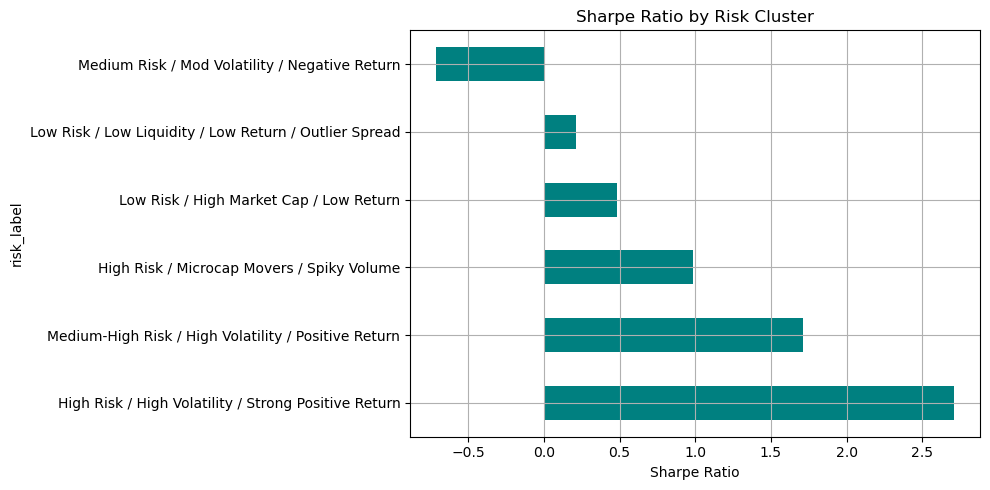

In [167]:
cluster_perf = calculate_risk_cluster_stats(risk_df)
plot_cluster_performance(cluster_perf)

In [168]:
coin_category_map = {
    'Tether': 'Stablecoin',
    'USD Coin': 'Stablecoin',
    'Dai': 'Stablecoin',
    'Bitcoin': 'Layer-1',
    'Ethereum': 'Layer-1',
    'Cardano': 'Layer-1',
    'Compound Coin': 'DeFi',
    'Dogecoin': 'Meme',
    'Pepe Cash': 'Meme',
    # ...add more if possible in the future
}

In [169]:
#Add the category mapping to dataframe
risk_df['category'] = risk_df['coin'].map(coin_category_map).fillna('Not Mapped')

In [170]:
cluster_vs_cat = (
    risk_df.groupby(['risk_label', 'category'])
    .size()
    .reset_index(name='count')
    .assign(pct=lambda x: x['count'] / x.groupby('risk_label')['count'].transform('sum'))
)

# Display as table
print(cluster_vs_cat.pivot(index='risk_label', columns='category', values='pct').fillna(0))

category                                             Layer-1  Not Mapped  \
risk_label                                                                 
High Risk / High Volatility / Strong Positive R...  0.046875    0.953125   
High Risk / Microcap Movers / Spiky Volume          0.000000    0.750000   
Low Risk / High Market Cap / Low Return             0.882353    0.117647   
Low Risk / Low Liquidity / Low Return / Outlier...  1.000000    0.000000   
Medium Risk / Mod Volatility / Negative Return      0.072635    0.856419   
Medium-High Risk / High Volatility / Positive R...  0.125850    0.874150   

category                                            Stablecoin  
risk_label                                                      
High Risk / High Volatility / Strong Positive R...    0.000000  
High Risk / Microcap Movers / Spiky Volume            0.250000  
Low Risk / High Market Cap / Low Return               0.000000  
Low Risk / Low Liquidity / Low Return / Outlier...    0.000000  
M

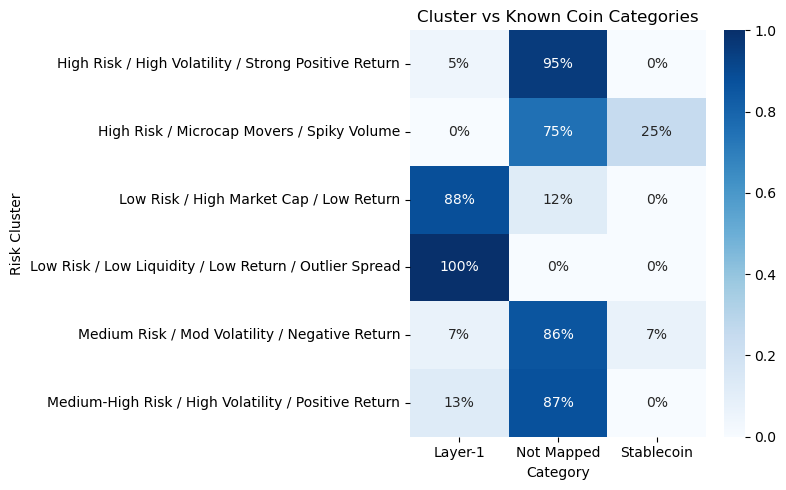

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = cluster_vs_cat.pivot(index='risk_label', columns='category', values='pct').fillna(0)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".0%", cmap='Blues')
plt.title('Cluster vs Known Coin Categories')
plt.xlabel('Category')
plt.ylabel('Risk Cluster')
plt.tight_layout()
plt.show()

category                                             Layer-1  Stablecoin
risk_label                                                              
High Risk / High Volatility / Strong Positive R...  1.000000    0.000000
High Risk / Microcap Movers / Spiky Volume          0.000000    1.000000
Low Risk / High Market Cap / Low Return             1.000000    0.000000
Low Risk / Low Liquidity / Low Return / Outlier...  1.000000    0.000000
Medium Risk / Mod Volatility / Negative Return      0.505882    0.494118
Medium-High Risk / High Volatility / Positive R...  1.000000    0.000000


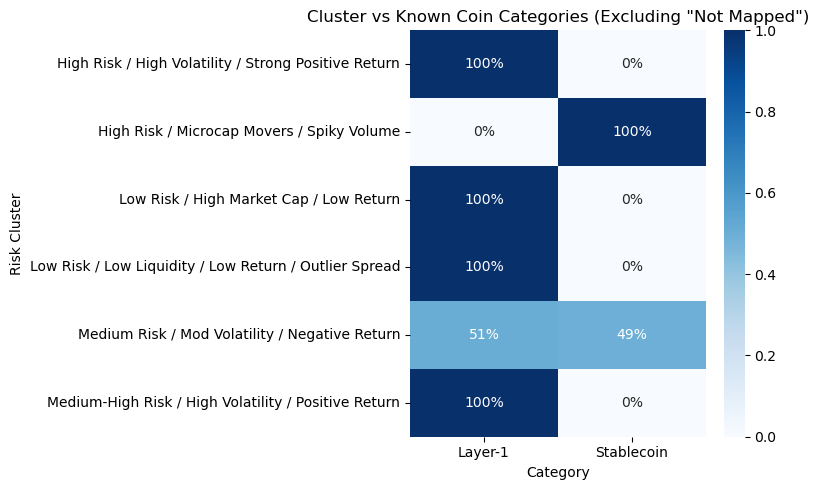

In [172]:
# Filter out coins categorized as 'Not Mapped'
filtered_df = risk_df[risk_df['category'] != 'Not Mapped']

# Recalculate cluster vs category counts and percentages excluding 'Not Mapped'
cluster_vs_cat = (
    filtered_df.groupby(['risk_label', 'category'])
    .size()
    .reset_index(name='count')
    .assign(pct=lambda x: x['count'] / x.groupby('risk_label')['count'].transform('sum'))
)

# Display as pivot table (optional)
pivot = cluster_vs_cat.pivot(index='risk_label', columns='category', values='pct').fillna(0)
print(pivot)

# Plot heatmap excluding 'Not Mapped'
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".0%", cmap='Blues')
plt.title('Cluster vs Known Coin Categories (Excluding "Not Mapped")')
plt.xlabel('Category')
plt.ylabel('Risk Cluster')
plt.tight_layout()
plt.show()

In [ ]:
#Time Stability of Risk Profiles - good for identifying sticky coins that don't change or those that change too much
coin_cluster_changes = (
    risk_df.sort_values(['coin', 'end_date'])
    .groupby('coin')['risk_cluster']
    .apply(lambda x: (x != x.shift()).sum() - 1)
    .reset_index(name='cluster_transitions')
    .sort_values(by='cluster_transitions', ascending=False)
)

print(coin_cluster_changes.head())

       coin  cluster_transitions
37  Stellar                   16
47      XRP                   15
26   Monero                   13
7   Bitcoin                   12
27      NEM                   12


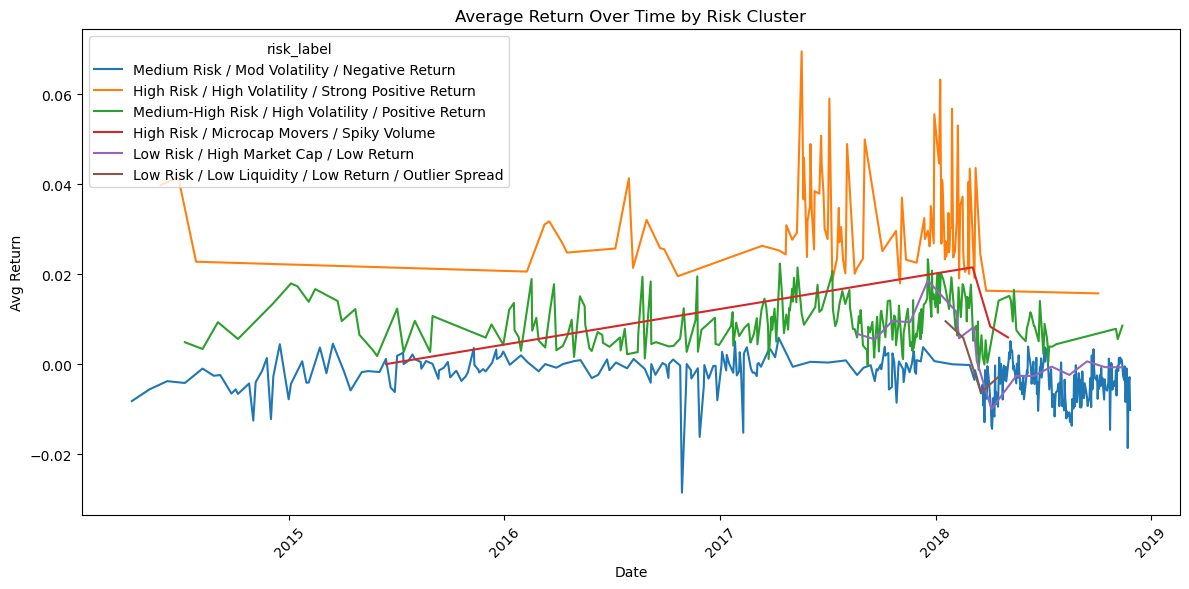

In [175]:
#Cluster wise return and volatility profiles over time
cluster_trends = (
    risk_df.groupby(['end_date', 'risk_label'])
    .agg(avg_return=('avg_return', 'mean'), volatility=('volatility', 'mean'))
    .reset_index()
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_trends, x='end_date', y='avg_return', hue='risk_label')
plt.title("Average Return Over Time by Risk Cluster")
plt.xlabel("Date")
plt.ylabel("Avg Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [179]:
#Cluster Consistency as % of Time in Dominant Cluster
# Step 1: Count how many times each coin appears in each cluster
cluster_counts = risk_df.groupby(['coin', 'risk_label']).size().reset_index(name='count')

# Step 2: Total number of entries per coin
total_counts = risk_df.groupby('coin').size().reset_index(name='total')

# Step 3: Merge and compute percentage
cluster_counts = cluster_counts.merge(total_counts, on='coin')
cluster_counts['percentage'] = cluster_counts['count'] / cluster_counts['total']

# Step 4: For each coin, select the dominant cluster (highest %)
dominant_cluster = (
    cluster_counts.sort_values(['coin', 'percentage'], ascending=[True, False])
    .drop_duplicates('coin')
    .reset_index(drop=True)
    .rename(columns={'risk_label': 'dominant_risk_label', 'percentage': 'dominant_cluster_pct'})
)

# Format
dominant_cluster['dominant_cluster_pct'] = (dominant_cluster['dominant_cluster_pct'] * 100).round(2)

# Step 5: Sort by dominant cluster count
dominant_cluster = dominant_cluster.sort_values(by='count', ascending=False)

# View
print(dominant_cluster[['coin', 'dominant_risk_label', 'dominant_cluster_pct', 'count']].head())
dominant_cluster

        coin                                dominant_risk_label  \
40    Tether     Medium Risk / Mod Volatility / Negative Return   
47       XRP     Medium Risk / Mod Volatility / Negative Return   
24  Litecoin     Medium Risk / Mod Volatility / Negative Return   
37   Stellar     Medium Risk / Mod Volatility / Negative Return   
26    Monero  Medium-High Risk / High Volatility / Positive ...   

    dominant_cluster_pct  count  
40                 97.67     42  
47                 68.42     39  
24                 68.42     39  
37                 64.00     32  
26                 53.85     28  


,coin,dominant_risk_label,count,total,dominant_cluster_pct
40,Tether,Medium Risk / Mod Volatility / Negative Return,42,43,97.67
47,XRP,Medium Risk / Mod Volatility / Negative Return,39,57,68.42
24,Litecoin,Medium Risk / Mod Volatility / Negative Return,39,57,68.42
37,Stellar,Medium Risk / Mod Volatility / Negative Return,32,50,64.00
26,Monero,Medium-High Risk / High Volatility / Positive ...,28,52,53.85
13,Dash,Medium Risk / Mod Volatility / Negative Return,26,55,47.27
7,Bitcoin,Medium-High Risk / High Volatility / Positive ...,21,57,36.84
27,NEM,Medium Risk / Mod Volatility / Negative Return,19,42,45.24
36,Steem,Medium Risk / Mod Volatility / Negative Return,17,29,58.62
23,Lisk,Medium Risk / Mod Volatility / Negative Return,16,28,57.14


In [180]:
#Export risk dataframe such that it can be loaded into dashboard
risk_df.to_csv('risk_df.csv', index=False)